# Imports

In [1]:
%matplotlib inline
# Core
import numpy as np
from PIL import Image
import cv2
from imageio import imwrite
import statistics as stats
import pandas as pd

import numpy as np
import lmfit
from lmfit import Model

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Image Helper Functions

In [3]:
# Showing image
def showImage(img, title1 = "Original"):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img), plt.title(title1)
  plt.show()

In [4]:
# Getting image from path
def getImage(file_path=""):
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    img = cv2.imread(file_path)
    
    return img

In [5]:
# To greyscale image
def grayscale(img):
    copy = img.copy()
    copy[:, :, 0] = copy[:, :, 2]  = 0
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    return gray

# Image Processing

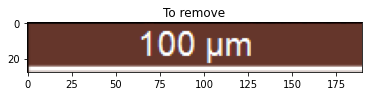

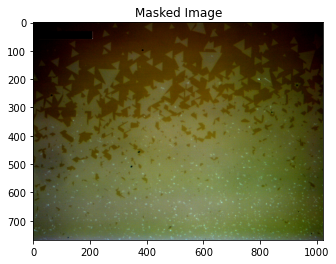

In [6]:
# setting up
img = getImage("img2.png")

# finding area to mask off
showImage(img[32:60,20:210,:], "To remove")

# create mask to remove top left part
mask = np.full(img.shape[:2], 255,np.uint8)
mask[32:60,20:210] = 0
masked_img = cv2.bitwise_and(img,img,mask = mask)
showImage(masked_img, "Masked Image")

gray = grayscale(masked_img)

# Visualization

## Images

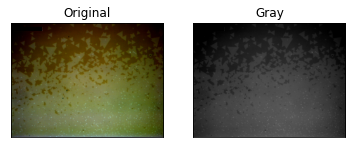

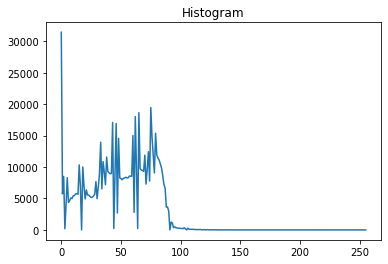

In [7]:
# showing images
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Gray"), plt.xticks([]), plt.yticks([])
plt.show()

# creating histograms of grayscaled image
histMask = cv2.calcHist([gray],[0],mask,[256],[0,256])
plt.title("Histogram")
plt.plot(histMask);plt.show()

## Intensity within a single row

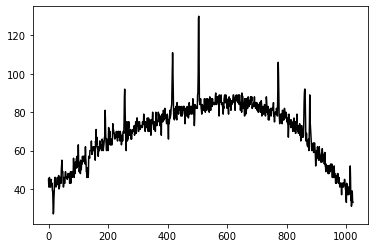

In [8]:
grayLine = gray[650,:]

plt.plot(np.arange(len(grayLine)),grayLine,"k");plt.show()

# 2D Gaussian Curve Fitting

## 2D Gaussian Function

In [9]:
def gaussian(coordinates, amp ,cenX, cenY, widthX, widthY):
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    return amp * np.exp(-(x-cenX)**2 / (2*widthX**2)-(y-cenY)**2 / (2*widthY**2))

## Initializing Data

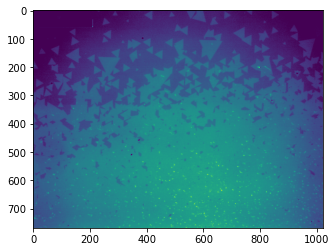

In [10]:
# initializing data arrays
width = len(gray[0])
height = len(gray[:,0])

data = np.empty((width*height,3))

#widthArray = np.linspace(-width/2 , width/2, width)
#heightArray = np.linspace(-height/2 , height/2, height)

widthArray = np.arange(len(gray[0]))
heightArray = np.arange(len(gray[:,0]))

xx, yy = np.meshgrid(widthArray,heightArray)

data[:,0] = xx.flatten()
data[:,1] = yy.flatten()
data[:,2] = gray[:,:].flatten()

plt.imshow(data[:, 2].reshape(height,width))

## Curve Fitting

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 786432
    # variables        = 5
    chi-square         = 2.7082e+08
    reduced chi-square = 344.367352
    Akaike info crit   = 4594111.87
    Bayesian info crit = 4594169.75
[[Variables]]
    amp:     71.3111818 +/- 0.07240836 (0.10%) (init = 1)
    cenX:    542.265737 +/- 0.44210484 (0.08%) (init = 500)
    cenY:    545.315603 +/- 0.47313076 (0.09%) (init = 300)
    widthX:  535.473052 +/- 0.51332430 (0.10%) (init = 10)
    widthY:  545.653011 +/- 2.78489572 (0.51%) (init = 100)
[[Correlations]] (unreported correlations are < 0.600)
    C(amp, widthX) = -0.821
{'amp': 71.31118179784814, 'cenX': 542.2657367247109, 'cenY': 545.3156032793604, 'widthX': 535.4730517835612, 'widthY': 545.653010692387}


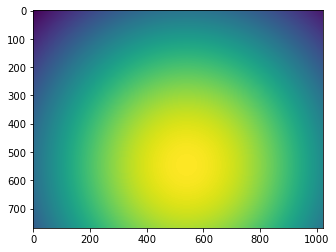

In [11]:
defaultAmp = 1
defaultCenX = 500
defaultCenY = 300
defaultWidthX = 10
defaultWidthY = 100

model = Model(gaussian)

model.set_param_hint('amp', value=1, min=0, max=100)
model.set_param_hint('cenX', value=defaultCenX, min=defaultCenX-width/2, max=defaultCenX+width/2)
model.set_param_hint('cenY', value=defaultCenY, min=defaultCenY -height/2, max=defaultCenY+height/2)
model.set_param_hint('widthX', value=defaultWidthX, min=10, max=1000)
model.set_param_hint('widthY', value=defaultWidthY, min=10, max=600)
params = model.make_params()
result = model.fit(data[:, 2], coordinates=data[:, 0:2], params=params)
print(result.fit_report(min_correl=0.60))
print(result.best_values)
plt.imshow(result.best_fit.reshape(height,width))

## Visualisation of Curve Fitting

# Thresholding

## Helper Function

In [12]:
# Open and Close morph
def morph(img, openIter = 3, closeIter = 3):
    clean = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=closeIter)
    return clean

## Adaptive Thresholding

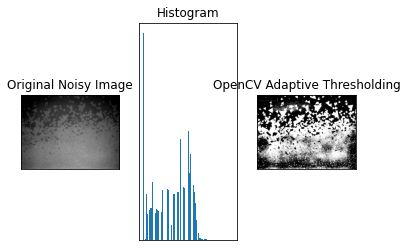

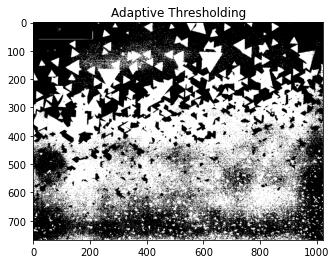

In [13]:
def adaptiveThresholding(img, blockSize=505, C=-2):
    gray = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(gray,'gray')
    plt.title("OpenCV Adaptive Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.show()
    return gray
showImage(adaptiveThresholding(gray, blockSize=505, C=0), "Adaptive Thresholding")

## Otsu Thresholding (Global)

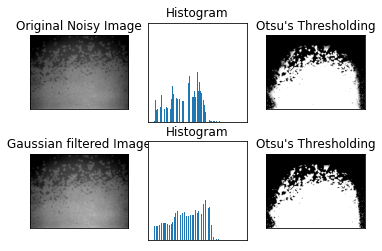

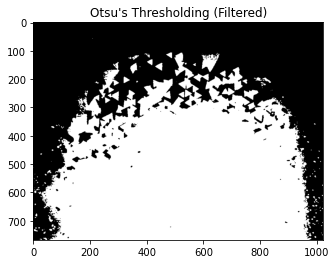

In [14]:
def otsuThresholding(img):
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    plt.subplot(2,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,3),plt.imshow(th2,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.subplot(2,3,4),plt.imshow(blur,'gray')
    plt.title('Gaussian filtered Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,5),plt.hist(blur.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,6),plt.imshow(th3,'gray')
    plt.title("Otsu's Thresholding"), plt.xticks([]), plt.yticks([])   

    plt.show()
    return th3

showImage(otsuThresholding(gray),"Otsu's Thresholding (Filtered)")

## Attempt to split into subimages and apply Otsu

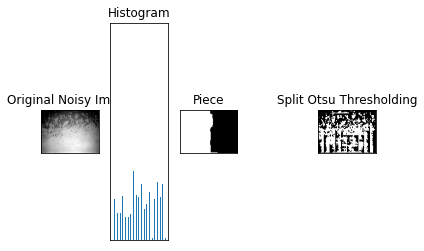

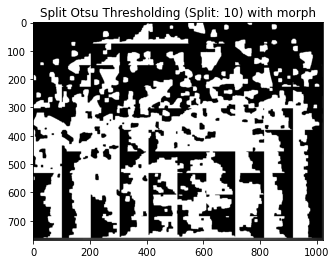

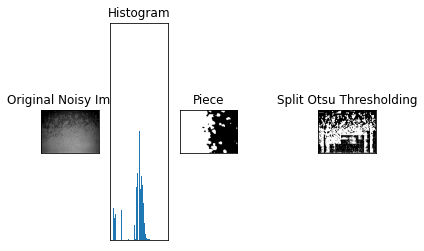

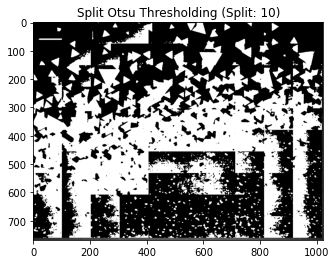

In [15]:
def splitOtsu(img, splitNo, kernel):
    blur = cv2.GaussianBlur(img,kernel,0)
    height,width=img.shape[:2]
    
    for heightIndex in range(splitNo):
        for widthIndex in range(splitNo):
            heightFactor = height//splitNo
            startSplitHeight = heightIndex*heightFactor
            endSplitHeight = (heightIndex+1)*heightFactor
            
            widthFactor = width//splitNo
            startSplitWidth = widthIndex*widthFactor
            endSplitWidth = (widthIndex+1)*widthFactor
            
            ret3,th3 = cv2.threshold(blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth]=th3 
             
    plt.subplot(1,5,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,3),plt.imshow(th3,'gray')
    plt.title('Piece'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,5),plt.imshow(blur,'gray')
    plt.title("Split Otsu Thresholding"), plt.xticks([]), plt.yticks([])
    
    plt.show()
    
    return blur

split = 10
plt.imshow(cv2.cvtColor(splitOtsu(morph(gray,5,3),split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ") with morph")
plt.show()

plt.imshow(cv2.cvtColor(splitOtsu(gray,split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ")")
plt.show()